<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = ('capstone_user_identification')

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def add_features(features, session_times, project_file, session_length, added_zeros):
    for i in range(session_length - 1 - added_zeros):
        features = np.append(features, session_times[i + 1] - session_times[i])  #time_diff
    for i in range(added_zeros):
        features = np.append(features, pd.Timedelta(seconds=0))  #time_diff for no_sites
    features[session_length: 2 * session_length] = np.array(list(map(pd.Timedelta.total_seconds, features[session_length: 2 * session_length])))  # to seconds
    features = np.append(features, features[session_length: 2 * session_length].sum()).astype(int)  # timespan
    features = np.append(features, len(np.unique(features[0: session_length])) - bool(added_zeros))  # unique_sites
    features = np.append(features, session_times[0].hour)  # start_hour
    features = np.append(features, session_times[0].day_of_week)  # day_of_week
    return features

def add_more_features(features, session_times, project_file, session_length, added_zeros):
    features = np.append(features, features[19] / (session_length - float(added_zeros)))  # avg_time
    features = np.append(features, session_times[0].quarter)  # quarter
    features = np.append(features, pd.to_datetime(session_times[0]).day)  # day
    return features

def get_session_df(project_files, site_dict, feature_names, session_length, window_size, more_features=False):
    data = []
    
    for project_file in tqdm(project_files):
        df = pd.read_csv(project_file)
        sites = np.array(df['site'])  # sites == df['site'] for speeding calculations
        times = np.array(list(map(pd.Timestamp, df['timestamp'])))
        for ind in range(0, len(sites), window_size):
            session_sites = sites[ind: ind + session_length]
            session_times = times[ind: ind + session_length]
            features = np.array(list(map(lambda site_name: site_dict[site_name][0], session_sites)))  # sites
            added_zeros = 0
            while len(features) != session_length:
                features = np.append(features, 0)
                added_zeros += 1
            features = add_features(features, session_times, project_file, session_length, added_zeros)
            if more_features:
                features = add_more_features(features, session_times, project_file, session_length, added_zeros)
            features = np.append(features, int(project_file[-8: -4]))  # target
            data.append(features)
        
    session_df = pd.DataFrame(data, columns=feature_names)
    return session_df

def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    project_files = glob(os.path.join(path_to_csv_files, '*.csv'))  # Collect all file pathes
    project_files.sort()  # It's more convenient to sort users
    site_dict = pickle.load(open(site_freq_path, "rb"))
    session_df = get_session_df(project_files, site_dict, feature_names, session_length, window_size)
    return session_df

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 313.09it/s]


In [5]:
train_data_toy.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,4,2,2,9,2,1,7,6,8,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,4,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,4,2,5,5,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,3,1,2,1,2,1,1,6,11,3,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,3,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


In [6]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,4,2,2,9,2,1,7,6,8,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,4,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,4,2,5,5,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,3,1,2,1,2,1,1,6,11,3,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,3,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [7]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.44it/s]


Wall time: 3.04 s


In [8]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,192,577,134,3,134,134,3,134,203,134,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,425,193,687,254,134,31,394,3841,218,55,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,55,3,55,55,5,293,425,340,908,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,473,4015,473,55,55,55,55,980,201,123,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,348,55,5,3837,258,212,3937,2157,676,2157,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [9]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=feature_names, session_length=10)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:31<00:00,  4.69it/s]


Wall time: 33 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [10]:
new_features = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']
new_features_10users = train_data_10users[new_features]
new_features_150users = train_data_150users[new_features]

In [11]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [12]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [13]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

Text(0, 0.5, 'Кол-во пользователей')

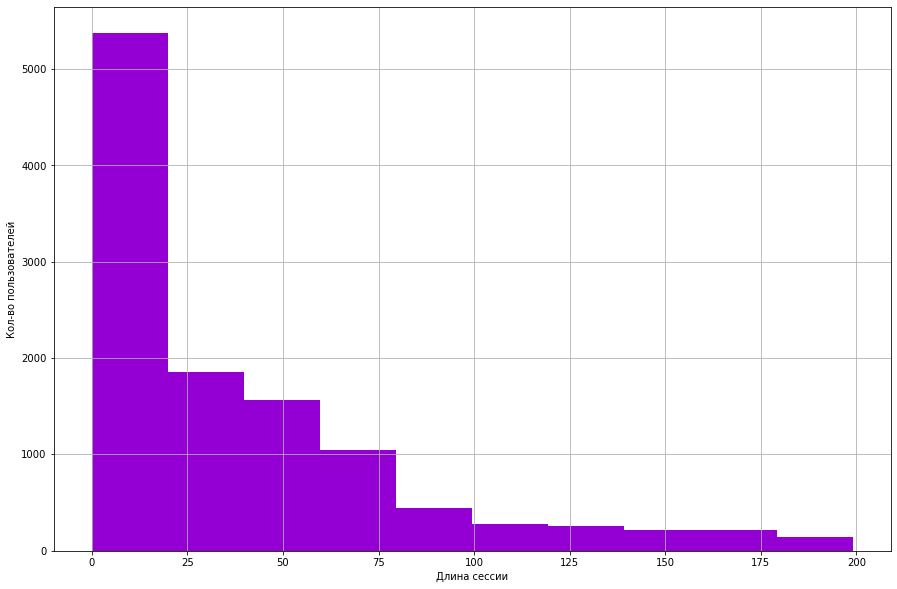

In [14]:
ax = train_data_10users[train_data_10users['session_timespan'] < 200]['session_timespan'].plot(figsize=(15,10), kind='hist', color='darkviolet', grid=True)
ax.set_xlabel("Длина сессии")
ax.set_ylabel("Кол-во пользователей")

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

Text(0, 0.5, 'Кол-во пользователей')

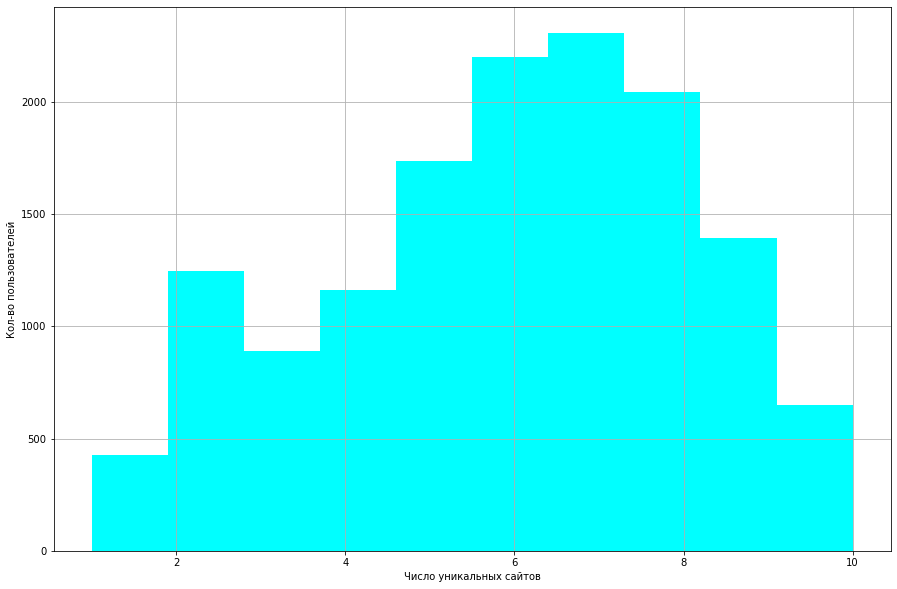

In [15]:
ax = train_data_10users['#unique_sites'].plot(figsize=(15,10), kind='hist', color='aqua', bins=10, grid=True)
ax.set_xlabel("Число уникальных сайтов")
ax.set_ylabel("Кол-во пользователей")

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

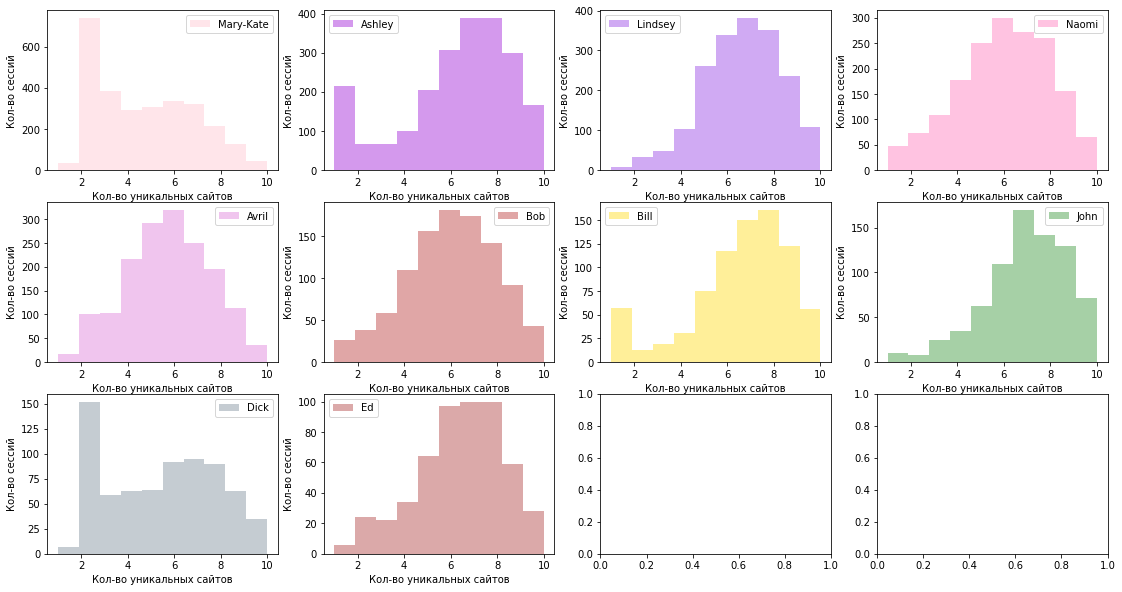

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(19, 10))

# как вариант, можно и по-другому
for idx, name in  enumerate(color_dic): 
     sns.distplot(train_data_10users[train_data_10users['target'] == name]['#unique_sites'], color = color_dic[name], kde=False, ax=axes[idx//4, idx%4], bins=10, label=name)
     axes[idx//4, idx%4].set_xlabel("Кол-во уникальных сайтов")
     axes[idx//4, idx%4].set_ylabel("Кол-во сессий")
     axes[idx//4, idx%4].legend()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

Text(0, 0.5, 'Кол-во сессий')

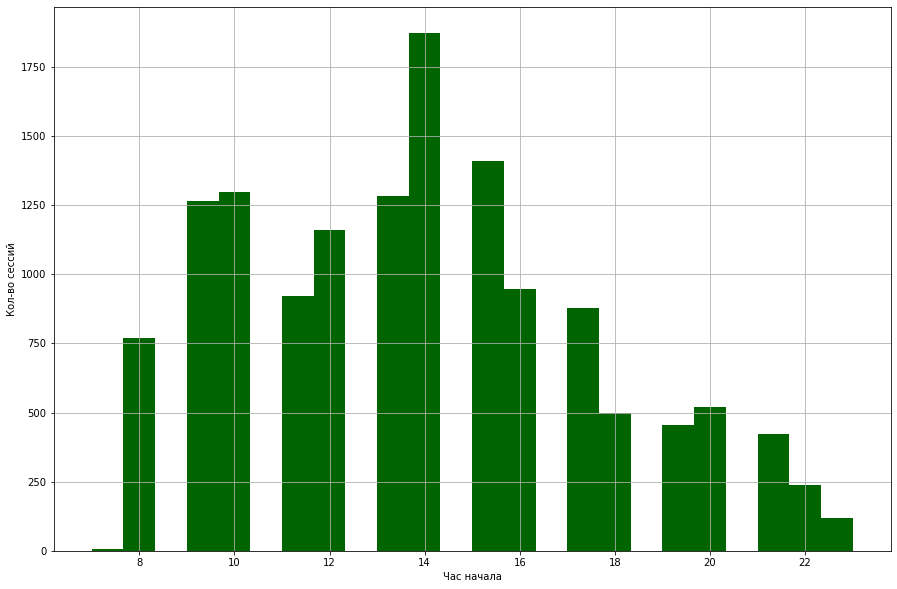

In [17]:
ax = train_data_10users['start_hour'].plot(figsize=(15,10), kind='hist', color='darkgreen', bins=24, grid=True)
ax.set_xlabel("Час начала")
ax.set_ylabel("Кол-во сессий")

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

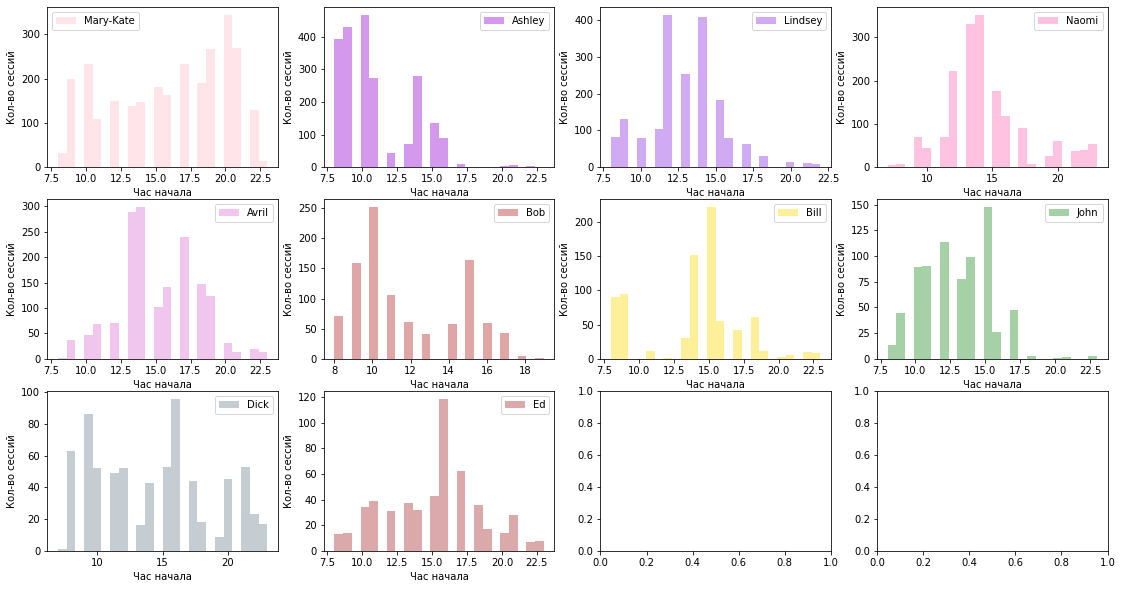

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(19, 10))

# как вариант, можно и по-другому
for idx, name in  enumerate(color_dic): 
     sns.distplot(train_data_10users[train_data_10users['target'] == name]['start_hour'], color = color_dic[name], kde=False, ax=axes[idx//4, idx%4], bins=24, label=name)
     axes[idx//4, idx%4].set_xlabel("Час начала")
     axes[idx//4, idx%4].set_ylabel("Кол-во сессий")
     axes[idx//4, idx%4].legend()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

Text(0, 0.5, 'Кол-во сессий')

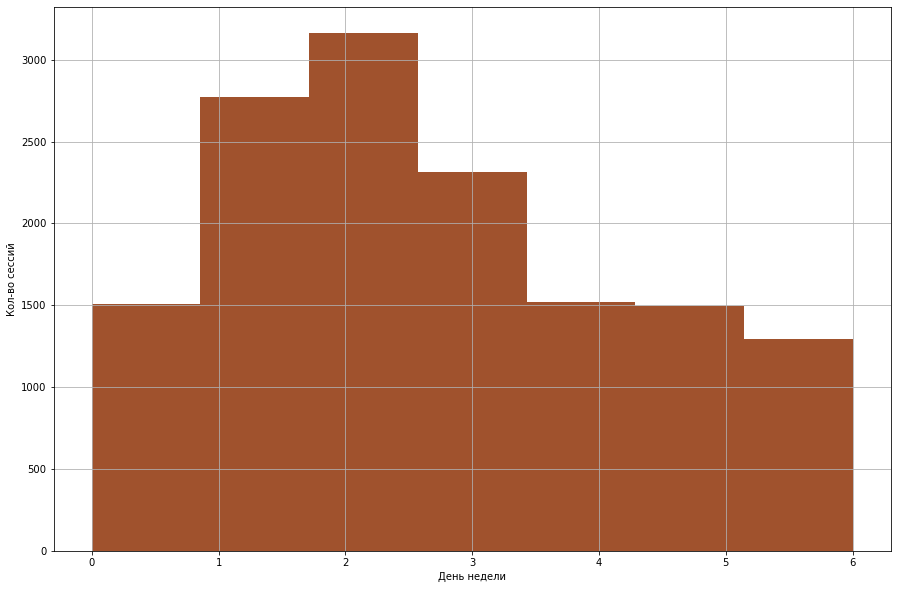

In [19]:
ax = train_data_10users['day_of_week'].plot(figsize=(15,10), kind='hist', color='sienna', grid=True, bins=7)
ax.set_xlabel("День недели")
ax.set_ylabel("Кол-во сессий")

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

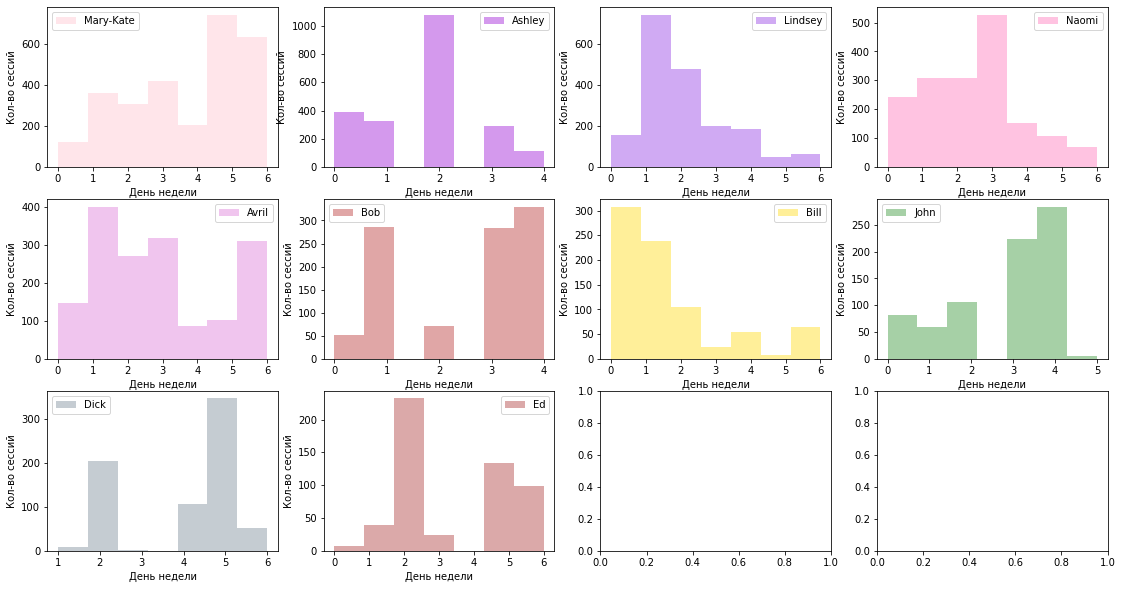

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(19, 10))

# как вариант, можно и по-другому
for idx, name in  enumerate(color_dic): 
     sns.distplot(train_data_10users[train_data_10users['target'] == name]['day_of_week'], color = color_dic[name], kde=False, ax=axes[idx//4, idx%4], label=name, bins=7)
     axes[idx//4, idx%4].set_xlabel("День недели")
     axes[idx//4, idx%4].set_ylabel("Кол-во сессий")
     axes[idx//4, idx%4].legend()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

John - пик начала сессии приходится на 4 день. Начинает сессию в отрезке от 10 до 12 или 14 до 15, этим значениям соответствуют пики Времени начала сессии. Среди уникальных сайтов преобладает 8, значений меньше 3 почти нет.

Bob - сессии в основном начинаются на 3-4 день недели, врьмя начала сесии чаще всего 10 чаов, еще один пик в 15 часов.В сессии как правило 6-7 уникальных сайтов.

Ashley - Сессии в основном начинаются на 2 день. первый пик на графике количества уникальных сайтов наблюдается в значении 1, затем идет спад и пик 7-9. Время начала сессии большая часть в 9-10, затем спад и немного сессий сосредоточены в 14-15, после этого сессий вообще не было или очень мало.

Bill - сессии в основном начинаются в начале недели.в гистограмме уникальных сайтов в сессии преобладает значение 8. Пик начала сессий приходится на значение 15.

Dick - сессии в основном начинаются в конце недели. в основном 2-3 сайта в сессии, остальных значений немного меньше и они почти равномерно распределены. То же самое можно сказать и о времени начала сессии, небольшой пик в значении 16-17.

Naomi - день начала сессии 3. количество уникальных сайтов в сессии увеличивается при движении вправо, достигает своего пика в отрезке 6-7, затем снова убывает. Время начала сессии имеет почти нормальное распределение (немного тяжелые хвосты), с пиком в значении 14.

Mary-Kate - сесии чаще всего начинаются на 5-6 день. больше всего 2 уникальных сайтов, затем идет резкий спад. График времени начала сессии почти равномерный с пиками в отрезках 9-10, 19-21.

Lindsey - резкий скачок в значении 1 затем постепенный спад. график распределения количества уникальных частот имеет вид нормального распределения, за исключением того, что график немного скошен вправо, с пиком в 7. Что касается графика времени начала сессии, то он имеет пики в значениях 12 и 14.

Avril - распределение почти равномерное, небольшой пик в значении 1. график распределения количества уникальных частот имеет вид нормального распределения с пиком в 6. График времени начала сессии с пиками в значениях 12 и 14.

Ed - сесии в основном начинаются на 2 день.в целом у пользователя сравнительно мало сессий по сравнению с остальными, пик в значении 8. Время начала сессии резкий скачок в значении 15, остальные значения распределены равномерно.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [21]:
with open(os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 'rb') as f:
    site_freq = pickle.load(f)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [22]:
top10_freqs = [y for x, y in list(site_freq.values())[0:10]]
top10_sites = list(site_freq.keys())[0:10]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

Text(0.5, 0, 'Частоты посещения')

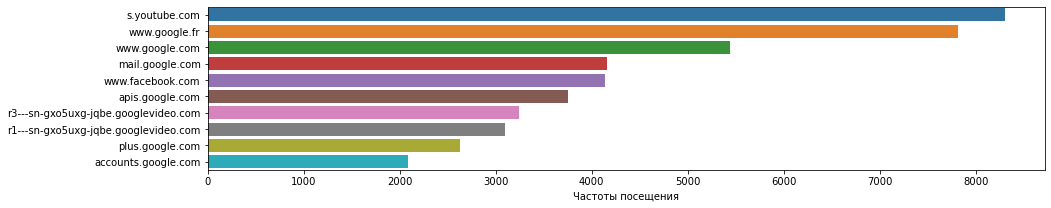

In [23]:
fig, ax = plt.subplots(figsize = (15, 3))
sns.barplot(top10_freqs, top10_sites, ax = ax)
ax.set_xlabel('Частоты посещения')

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [24]:
train_data_10users['session_timespan'].median()

37.0

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [25]:
train_data_10users['day_of_week'].median()

2.0

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [26]:
train_data_150users['start_hour'].median()

13.0

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [27]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [28]:
def feature_engineering(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    project_files = glob(os.path.join(path_to_csv_files, '*.csv'))  # Collect all file pathes
    project_files.sort()  # It's more convenient to sort users
    site_dict = pickle.load(open(site_freq_path, "rb"))
    session_df = get_session_df(project_files, site_dict, feature_names, session_length, window_size, True)
    avg_time = session_df['avg_time']
    session_df = session_df.astype('int')
    session_df['avg_time'] = avg_time
    return session_df

In [29]:
new_feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'avg_time', 'quarter', 'day', 'target']

new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=new_feature_names, session_length=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.51it/s]


In [30]:
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                  feature_names=new_feature_names, session_length=10)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

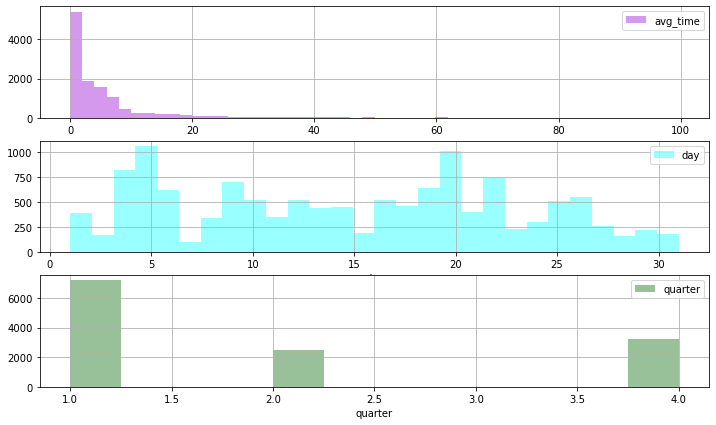

In [31]:
new_features = ['avg_time', 'day', 'quarter']
colors = ['darkviolet', 'aqua', 'darkgreen']
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 7))

for i, feature in enumerate(new_features):
    sns.distplot(new_features_10users[new_features_10users['avg_time'] < 100][feature], ax=axes[i], 
                 kde=False, label=feature, color=colors[i])
    axes[i].grid()
    axes[i].legend()

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [32]:
selected_features_10users = ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'avg_time', 'quarter', 'day', 'target']
selected_features_150users = ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'avg_time', 'quarter', 'day', 'target']

In [33]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 